In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Data with photo

In [ ]:
import cv2
import time

In [ ]:
def get_frame(cam_port, label):
    cap = cv2.VideoCapture(cam_port)
    count = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        #path = '/content/gdrive/MyDrive/Data_for_RNN/' + label + '/img_' + str(count) + '.jpeg'
        path = '/home/pi/Learnig_repo/images/' + label + '_' + str(count) + '.jpeg'
        count += 1
        cv2.imwrite(path, frame)
        #print(f'writing img: {path}')
        print('writing img: ', path)
        time.sleep(0.5)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


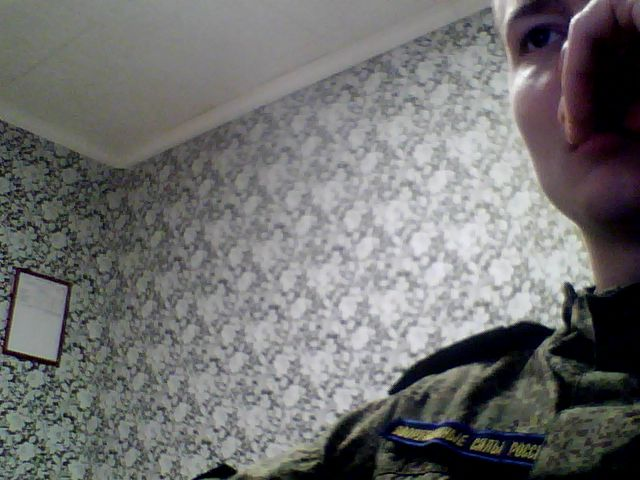

In [ ]:
from IPython.display import Image
for i in range(3):
  try:
    filename = take_photo()
    filename = 'enemy_'+str(i)+'-'+fi
    print('Saved to {}'.format(filename))
  
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

In [ ]:
get_frame(1, 'enemy')

# capture key points

In [ ]:
import os 
import json

import cv2
import torch
import torchvision.transforms as transforms
import PIL.Image

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.chdir('/content/gdrive/MyDrive/trt_pose')
os.getcwd()

'/content/gdrive/MyDrive/trt_pose'

In [ ]:
!cd /content/gdrive/MyDrive/trt_pose && python3 setup.py install

In [ ]:
import trt_pose.models

In [ ]:
def coco_category_to_topology(coco_category):
    """Gets topology tensor from a COCO category
    """
    skeleton = coco_category['skeleton']
    K = len(skeleton)
    topology = torch.zeros((K, 4)).int()
    for k in range(K):
        topology[k][0] = 2 * k
        topology[k][1] = 2 * k + 1
        topology[k][2] = skeleton[k][0] - 1
        topology[k][3] = skeleton[k][1] - 1
    return topology

In [ ]:
with open('tasks/human_pose/human_pose.json', 'r') as f:
        human_pose = json.load(f)
        topology = coco_category_to_topology(human_pose)

In [ ]:
num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model_keypoint = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
MODEL_WEIGHTS = '/content/gdrive/MyDrive/resnet18_baseline_att_224x224_A_epoch_249.pth'

model_keypoint.load_state_dict(torch.load(MODEL_WEIGHTS))

<All keys matched successfully>

In [ ]:
img_example = cv2.imread('example.jpg')
print(f'Loading done: {type(img_example)}, {img_example.shape}')

Loading done: <class 'numpy.ndarray'>, (853, 1280, 3)


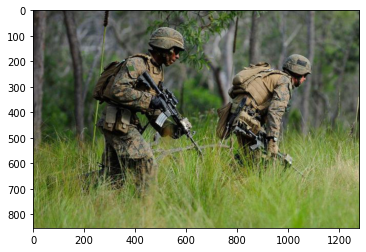

In [ ]:
plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))

In [ ]:
from trt_pose.draw_objects import DrawObjects

draw_objects = DrawObjects(topology)

In [ ]:
import trt_pose.plugins


class ParseObjects(object):
    
    def __init__(self, topology, cmap_threshold=0.1, link_threshold=0.1, cmap_window=5, line_integral_samples=7, max_num_parts=100, max_num_objects=100):
        self.topology = topology
        self.cmap_threshold = cmap_threshold
        self.link_threshold = link_threshold
        self.cmap_window = cmap_window
        self.line_integral_samples = line_integral_samples
        self.max_num_parts = max_num_parts
        self.max_num_objects = max_num_objects
    
    def __call__(self, cmap, paf):
        
        peak_counts, peaks = trt_pose.plugins.find_peaks(cmap, self.cmap_threshold, self.cmap_window, self.max_num_parts)
        normalized_peaks = trt_pose.plugins.refine_peaks(peak_counts, peaks, cmap, self.cmap_window)
        score_graph = trt_pose.plugins.paf_score_graph(paf, self.topology, peak_counts, normalized_peaks, self.line_integral_samples)
        connections = trt_pose.plugins.assignment(score_graph, self.topology, peak_counts, self.link_threshold)
        object_counts, objects =trt_pose.plugins.connect_parts(connections, self.topology, peak_counts, self.max_num_objects)
        
        return object_counts, objects, normalized_peaks

In [ ]:
mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

In [ ]:
def transform(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

In [ ]:
def get_keypoints(img):
    data = transform(img)
    cmap, paf = model_keypoint(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    return(cmap, paf)

In [ ]:
cmap, paf = get_keypoints(img_example)
print(f'Network results:\ncmap:{cmap.shape}\npaf:{paf.shape}')

Network results:
cmap:torch.Size([1, 18, 216, 320])
paf:torch.Size([1, 42, 216, 320])


In [ ]:
cmap[0,1].shape

torch.Size([216, 320])

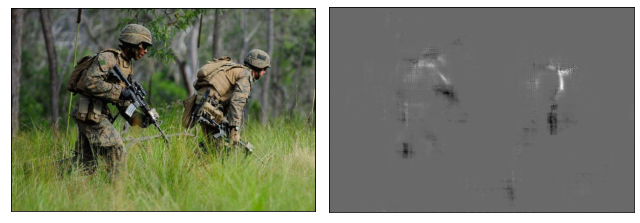

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, count in zip(axs.flat, range(2)):
    if count == 0:
      img = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)
    else:
      img = paf[0].mean(0).cpu()
    ax.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

# Draw conv

In [ ]:
import matplotlib.transforms as mtransforms
import numpy as np


In [ ]:
type(model_keypoint)

torch.nn.modules.container.Sequential

In [ ]:
help(torch.nn.modules.container.Sequential)

In [ ]:
first = model_keypoint[0]

In [ ]:
type(first)

trt_pose.models.resnet.ResNetBackbone

In [ ]:
first.state_dict().keys()

odict_keys(['resnet.conv1.weight', 'resnet.bn1.weight', 'resnet.bn1.bias', 'resnet.bn1.running_mean', 'resnet.bn1.running_var', 'resnet.bn1.num_batches_tracked', 'resnet.layer1.0.conv1.weight', 'resnet.layer1.0.bn1.weight', 'resnet.layer1.0.bn1.bias', 'resnet.layer1.0.bn1.running_mean', 'resnet.layer1.0.bn1.running_var', 'resnet.layer1.0.bn1.num_batches_tracked', 'resnet.layer1.0.conv2.weight', 'resnet.layer1.0.bn2.weight', 'resnet.layer1.0.bn2.bias', 'resnet.layer1.0.bn2.running_mean', 'resnet.layer1.0.bn2.running_var', 'resnet.layer1.0.bn2.num_batches_tracked', 'resnet.layer1.1.conv1.weight', 'resnet.layer1.1.bn1.weight', 'resnet.layer1.1.bn1.bias', 'resnet.layer1.1.bn1.running_mean', 'resnet.layer1.1.bn1.running_var', 'resnet.layer1.1.bn1.num_batches_tracked', 'resnet.layer1.1.conv2.weight', 'resnet.layer1.1.bn2.weight', 'resnet.layer1.1.bn2.bias', 'resnet.layer1.1.bn2.running_mean', 'resnet.layer1.1.bn2.running_var', 'resnet.layer1.1.bn2.num_batches_tracked', 'resnet.layer2.0.conv1

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, count in zip(axs.flat, range(28,46)):
    if count == 38:
      count = 5
    if count == 36:
      count = 1
    img = first.state_dict()['resnet.conv1.weight'][count].cpu()
    img = img.permute(1,2,0)
    image = ax.imshow(cv2.cvtColor(img.numpy(), cv2.COLOR_BGR2RGB), interpolation='bicubic')

fig.colorbar(image, ax=axs, anchor = (3.0, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
def do_plot(ax, Z, transform, cmap):
    im = ax.imshow(Z,
                   origin='lower',
                   extent=[-2, 4, -3, 2], clip_on=True, cmap=cmap)

    trans_data = transform + ax.transData
    im.set_transform(trans_data)

    # display intended extent of the image
    x1, x2, y1, y2 = im.get_extent()
    ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--",
            transform=trans_data)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-4, 4)

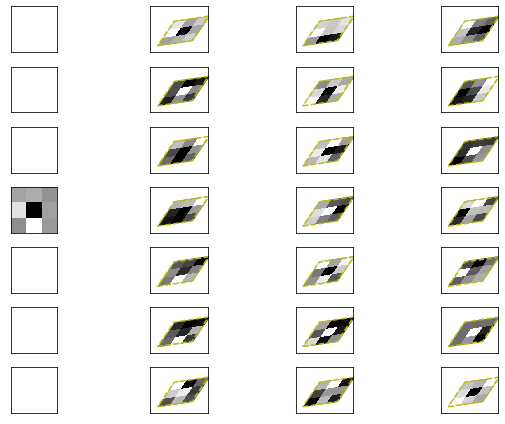

In [ ]:
image = first.state_dict()['resnet.layer1.0.conv1.weight'][0].cpu()
placeholder = np.ones((3,3))
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, count in zip(axs.flat, range(28)):
    if count==12:
      ax.imshow(image.mean(0), origin='lower', cmap='gray')
    elif (count%4==0):
      ax.imshow(255*placeholder,
                   origin='lower',  cmap='gray', vmin=1)
    else:
      do_plot(ax, image[count], mtransforms.Affine2D().skew_deg(30,10).scale(1, .85), 'gray')


plt.tight_layout()


# Create model

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = 12
n_categories = 2
simple_rnn = SimpleRNN(n_letters, n_hidden, n_categories)

For sequetial run use:

In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),

SyntaxError: ignored

In [ ]:
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5):
        super(LSTM_RNN, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.rnn = nn.LSTM(input_size, hidden_size, output_size)
        self.dense = nn.Linear(output_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.drop(output)
        dense = self.dense(output)
        return F.log_softmax(decoded, dim=1), hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = 12
n_categories = 2
lstm_rnn = LSTM_RNN(n_letters, n_hidden, n_categories)

# Train model

# Test model